<a href="https://colab.research.google.com/github/leeoos/sentence-classification/blob/main/src/hw1b_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 B

In [1]:
#@title Notebook set up
compare_tokenizers = False
use_cached = True
split_before = True
stanza_available = True

## TODO:

1. split before creating the dataset (as altenative)  --> DONE
2. change hyperparameters and network
3. evaluate simple baseline
4. implement complex baseline + evaluation
5. clean dataset (optional):
6. custom tokenizer (optional)

## Imports

In [2]:
#@title Addictional Modules

!pip install -q spacy
!python -m spacy download it_core_news_sm >> /dev/null

!pip install -q nltk

!pip install -q --timeout=100 stanza

# if allowed
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 16.1 MB/s eta 0:00:00


In [3]:
#@title Python Imports

# general imports
import os
import shutil
from tqdm.notebook import tqdm

# data manipulation
import json
import random
import subprocess
from pathlib import Path
from torchtext.vocab import Vocab, vocab
from collections import Counter, OrderedDict

# tokenization
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer

try:
  import stanza
except:
  print("Warning: stanza non available")
  stanza_available = False

# if allowed
from transformers import AutoTokenizer

# statistics
import numpy as np
import matplotlib as plt

# torch
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
  !nvidia-smi

### Update some packages ###
!pip install -q conllu
!pip install -q torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00


## Preprocessing

In [4]:
#@title Get Data

if not os.path.exists("sentence-classification"):
  !git clone -q https://github.com/leeoos/sentence-classification.git

# set up paths
train_path = Path("sentence-classification/data/sentipolc16_task1_train_data.jsonl")
test_path = Path("sentence-classification/data/sentipolc16_task1_test_data.jsonl")

def sample_random_lines(filename, num_lines=10, split=False):
    with open(filename, 'r') as file:
      lines = file.readlines()
    # Sample N random lines where N is num_lines or len(lines)
    sampled_lines = random.sample(lines, min(num_lines, len(lines)))

    train_path = filename
    val_path = ''

    sub_split_dir = "subsplit/"
    if os.path.exists(sub_split_dir):
      shutil.rmtree(sub_split_dir)

    if split:
      remaining_lines = [line for line in lines if line not in sampled_lines]
      os.makedirs(sub_split_dir, exist_ok=True)

      # save new train set
      train_path = Path(sub_split_dir + "train_sentipolc16.jsonl")
      remaining_lines[-1] = remaining_lines[-1].rstrip('\n') # remove last '\n'
      with open(train_path, 'w') as file:
        file.writelines(remaining_lines)

      # save new val set
      val_path = Path(sub_split_dir + "val_sentipolc16.jsonl")
      sampled_lines[-1] = sampled_lines[-1].rstrip('\n') # remove last '\n'
      with open(val_path, 'w') as file:
        file.writelines(sampled_lines)

    return sampled_lines, train_path, val_path

def print_random_json_lines(random_lines):
  for line in random_lines:
    try:
      json_data = json.loads(line.strip())
      print(json_data)
    except json.JSONDecodeError:
      print("Error decoding JSON from line:", line)

random_samples, _, _ = sample_random_lines(train_path, num_lines=10)
print_random_json_lines(random_samples)

{'id': 191491229932982273, 'text': 'A caccia di tabacco inglese #dunhill (@ Stazione Milano Centrale w/ 14 others) http://t.co/1ai88kJ7', 'topic': 'generico', 'choices': ['oggettivo', 'soggettivo'], 'label': 0}
{'id': 287300848348983298, 'text': '#confessionidadirectioner scleri quando la loro canzone è dal parrucchiere, dal dentista, al bar, al ristorante, alla radio. ajskdl.', 'topic': 'generico', 'choices': ['oggettivo', 'soggettivo'], 'label': 1}
{'id': 148437346528923648, 'text': 'il Governo Monti ha dichiarato di voler dare una svolta alla politica italiana. Preso da troppo entusiasmo, ha svoltato di 360°...', 'topic': 'politico', 'choices': ['oggettivo', 'soggettivo'], 'label': 1}
{'id': 396751606349578240, 'text': 'Ho i brividi', 'topic': 'generico', 'choices': ['oggettivo', 'soggettivo'], 'label': 1}
{'id': 189830191944708096, 'text': "@MircoBergamasco un RT per 1 dei pochi(secondo tanti l'unico altro)Mirko -anche se con la K- residente a Parigi bocca al lupo x lo scudo ;)", '

In [5]:
#@title Data Statistics

def statistics(path: Path, info:dict):
  with open(path, 'r', encoding='utf-8') as file:
    num_lines = 0
    num_subj = 0
    num_obj = 0

    for _ in file:
      foo = json.loads(_)
      if foo["choices"][foo["label"]] == "oggettivo":
        num_obj += 1
      else:
        num_subj +=1
      num_lines += 1

    perc_obj = round((num_obj/num_lines)*100, 1)
    perc_subj = round((num_subj/num_lines)*100, 1)
    print(f"Total number of samples: {num_lines}")
    print(f"Objetive samples: {perc_obj}%")
    print(f"Subjetive samples: {perc_subj}%")

    info["size"] = num_lines
    info["obj"] = num_obj
    info["subj"] = num_subj
    info["perc_obj"] = perc_obj
    info["perc_subj"] = perc_subj

train_info = {}
test_info = {}
print("Train-Set charateristics")
statistics(train_path, train_info)
print("\nTest-Set charateristics")
statistics(test_path, test_info)

Train-Set charateristics
Total number of samples: 7410
Objetive samples: 31.2%
Subjetive samples: 68.8%

Test-Set charateristics
Total number of samples: 2000
Objetive samples: 34.8%
Subjetive samples: 65.2%


In [6]:
#@title Tokenization

def set_dictionary(tokenizer_type: str):
  """
  This function is used to load the appropriate language dictionary
  for a given tokenizer
  """
  if tokenizer_type == "spacy":
   return spacy.load('it_core_news_sm')

  elif tokenizer_type == "nltk":
    return WordPunctTokenizer()

  elif tokenizer_type == "stanza":
    stanza.download('it')
    return stanza.Pipeline(lang='it', processors='tokenize')

  # if allowed
  elif tokenizer_type == "bert":
    return AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-xxl-cased")

  else:
    print(f"Error: invalit tokenizer type: {tokenizer_type}")


def get_tokenizer(tokenizer_type: str = "spacy"):
  """
  This function loads the appropriate language dictionary and returns the
  tokenizer according to the input string "tokenizer_type
  """

  if tokenizer_type == "stanza" and not stanza_available:
    tokenizer_type

  nlp = set_dictionary(tokenizer_type)

  def custom_tokenizer(text):
    """
    This inner function implements the actual tokenization process
    """

    if tokenizer_type not in ["spacy", "nltk", "stanza", "bert"]:
      print(f"Error: invalid tokenizer type: {tokenizer_type}")
      return []

    if tokenizer_type == "spacy":
      doc = nlp(text)
      tokens = [token.text for token in doc]
      return tokens

    elif tokenizer_type == "nltk":
      """This tokenizer splits also the symbols inside the URL (links in genral)
      this may be a disadvantage"""
      tokens = nlp.tokenize(text)
      return tokens

    elif tokenizer_type == "stanza":
      doc = nlp(text)
      tokens = [token.text for sentence in doc.sentences for token in sentence.tokens]
      return tokens

    # if allowed
    elif tokenizer_type == "bert":
      tokens = nlp.tokenize(text)
      token_ids = nlp.convert_tokens_to_ids(tokens)
      return tokens, token_ids

    else:
      print("Error")
      return []

  return custom_tokenizer

if compare_tokenizers:

  # get a generic tokenizer
  spacy_tokenizer = get_tokenizer("spacy")
  nltk_tokenizer = get_tokenizer("nltk")
  stanza_tokenizer = get_tokenizer("stanza")
  bert_tokenizer = get_tokenizer("bert")
  print()

  # test different tokenizer on the first  sentences of the train set
  for line in random_samples:
    text = json.loads(line)["text"]
    print(f"Original sentence: {text}")
    spacy_list = spacy_tokenizer(text)
    nltk_list = nltk_tokenizer(text)
    stanza_list = stanza_tokenizer(text)
    bert_list, _ = bert_tokenizer(text)
    print(f"Num of tokens: {len(spacy_list)}", end="\t")
    print(f"Sapcy tokenization: {spacy_list}")
    print(f"Num of tokens: {len(nltk_list)}", end="\t")
    print(f"Nltk tokenization: {nltk_list}")
    print(f"Num of tokens: {len(stanza_list)}", end="\t")
    print(f"Stanza tokenization: {stanza_list}")
    print(f"Num of tokens: {len(bert_list)}", end="\t")
    print(f"Bert tokenization: {bert_list}")
    print()

else:
  print("Tokenizer methods defined")

Tokenizer methods defined


In [7]:
#@title Data Cleaning
# STOPWORDS = set(stopwords.words('english'))
# def remove_stopwords(text):
#   return " ".join([word for word in text.split() if word not in STOPWORDS])

# df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))

import re
def remove_spl_chars(text):
  text = re.sub('[^a-zA-Z0-9]', ' ', text)
  text = re.sub('\s+', ' ', text)
  return text

# df['clean_text'] = df['clean_text'].apply(lambda x: remove_spl_chars(x))
print("Clean Json Datasets")

Clean Json Datasets


## Dataset

In [8]:
#@title Dataset Class

class Sentipolc16Dataset(Dataset):

  def __init__(
    self,
    input_file: Path,
    tokenizer_type: str = "spacy",
    device: str = "cuda",
    max_length : int = 1028
  ) -> None:
    super().__init__()

    # get specific tokenizer
    tokenizer = get_tokenizer(tokenizer_type)

    # get samples from input file
    self.samples = []
    result = subprocess.run(['wc', '-l', str(input_file)], stdout=subprocess.PIPE)
    total_lines = int(result.stdout.decode('utf-8').split()[0]) + 1
    with open(input_file, "r") as file:
      iterator = tqdm(file, total=total_lines, desc="Processing", unit="line")
      for line in iterator:
        sample = json.loads(line.strip())
        sample["tokens"] = tokenizer(sample["text"]) # adding new entry to original json sample
        self.samples.append(sample)

    # set device
    self.device = torch.device(device)

    # set max sentence length allowed
    self.max_length = max_length

    # initialize indexed data attribute but leave it None
    self.indexed_data: list[dict] | None = None

    # Keep track of padding id
    self.padding_id: int | None = None


  def get_raw_element(self, idx: int) -> dict:
    """
    Utility function that gets the raw sample corresponding to `idx`.
    """
    return self.samples[idx]

  def get_raw_tokens(self) -> list:
    return [sample["tokens"] for sample in self.samples]

  def __len__(self) -> int:
    return len(self.samples)

  def __getitem__(self, idx: int) -> dict:
    if self.indexed_data is None:
      raise RuntimeError(
        "Trying to retrieve samples but dataset has not been indexed yet!"
        + " Be sure to call `.index()` on this object."
        + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
      )
    return self.indexed_data[idx]

  def get_vocabulary(
    self,
    pad_token: str = "<pad>",
    unk_token: str = "<unk>",
    extra_tokens: list[str] = []
  ) -> Vocab:
    """
    Builds a `torchtext.vocab.Vocab` object from data stored in this object.
    """
    vocab_counter = dict(Counter(token for sent in self.samples for token in sent["tokens"]).most_common())
    vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
    vocabulary.set_default_index(vocabulary([unk_token])[0])

    return vocabulary

  def set_padding_id(self, value: int) -> None:
    """
    Set padding id after building vocabulary
    """
    self.padding_id = vocabulary([pad_token])[0]


  def index(self, vocabulary: Vocab) -> None:
    """
    Builds `self.indexed_data` by converting raw samples to input_ids following `vocabulary`
    """
    if self.indexed_data is not None:
      print("Dataset has already been indexed. Keeping old index...")
    else:
      indexed_data = []
      for sample in self.samples:
        indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
      self.indexed_data = indexed_data

  def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Batches together single elements of the dataset.
    This function:
    - converts each sentence made up of single input_ids to a padded tensor,
    - keeps track of the length of each sentence through `sequence_lengths`
    - builds a `labels` tensor storing the label for each sentence

    Args:
        raw_batch (list[dict]): a list of elements, as returned by the `__getitem__()` function.

    Returns:
        A tuple of three tensors, respectively `(sequence_lengths, padded_sequence, labels)`
    """
    if self.padding_id is None:
      raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

    # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
    sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
    padded_sequence = pad_sequence(
      (
        torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
        for sample in raw_batch
      ),
      batch_first=True,
      padding_value=self.padding_id
    )
    labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
    return sequence_lengths, padded_sequence, labels

## Dataloaders

In [9]:
#@title Make Torch Datasets

cached_dataset = os.path.exists("train_dataset.pth") and os.path.exists("test_dataset.pth") and os.path.exists("val_dataset.pth")

if (not use_cached) or (not cached_dataset):
  print("Making datasets...")

  pad_token, unk_token = "<pad>", "<unk>"

  if split_before:
    train_path = Path("sentence-classification/data/sentipolc16_task1_train_data.jsonl") # to be on the safe side
    split_size = int(train_info["size"]*0.1) # 10% of the train dataset
    _, train_path, val_path = sample_random_lines(train_path, num_lines=split_size, split=True)
    val_dataset = Sentipolc16Dataset(val_path, device=device)

  train_dataset = Sentipolc16Dataset(train_path, device=device)
  test_dataset = Sentipolc16Dataset(test_path, device=device)

  # build vocabulary
  vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
  padding_id = vocabulary([pad_token])[0]
  train_dataset.set_padding_id(padding_id)
  test_dataset.set_padding_id(padding_id)

  # indexing dataset
  train_dataset.index(vocabulary)
  test_dataset.index(vocabulary)

  # savinmg torch dataset
  torch.save(train_dataset, 'train_dataset.pth')
  torch.save(test_dataset, 'test_dataset.pth')

  print(f"\nTraining len: {len(train_dataset)}")
  print(f"Test len: {len(test_dataset)}")

  if split_before:
    val_dataset.set_padding_id(padding_id)
    val_dataset.index(vocabulary)
    torch.save(val_dataset, 'val_dataset.pth')

    print(f"Validation len: {len(val_dataset)}")


else:
  print("Using pre-build dataset!")


Making datasets...


Processing:   0%|          | 0/741 [00:00<?, ?line/s]

Processing:   0%|          | 0/6669 [00:00<?, ?line/s]

Processing:   0%|          | 0/2000 [00:00<?, ?line/s]


Training len: 6669
Test len: 2000
Validation len: 741


In [10]:
#@title Make Dataloaders

cached_dataset = os.path.exists("train_dataset.pth") and os.path.exists("test_dataset.pth") and os.path.exists("val_dataset.pth")

if use_cached and cached_dataset:
  print("Loading dataset from files")
  train_dataset = torch.load("train_dataset.pth")
  val_dataset = torch.load("val_dataset.pth")
  test_dataset = torch.load("test_dataset.pth")

if not split_before:
  # split train dataset to obtain validation dataset
  train_size = int(0.9*len(train_dataset))
  val_size = int(len(train_dataset) - train_size)
  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

  t_collate_fn = train_dataset.dataset._collate_fn
  v_collate_fn = val_dataset.dataset._collate_fn

else:
  t_collate_fn = train_dataset._collate_fn
  v_collate_fn = val_dataset._collate_fn

# make dataloaders
curr_batch_size = 64
print(f"Making torch dataloaders with batch size: {curr_batch_size}")
training_dataloader = DataLoader(train_dataset, batch_size=curr_batch_size, shuffle=True, collate_fn=t_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=curr_batch_size, shuffle=False, collate_fn=v_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=curr_batch_size, shuffle=False, collate_fn=test_dataset._collate_fn)
print("Done!")

Loading dataset from files
Making torch dataloaders with batch size: 64
Done!


## Baselines

## Modelling

In [11]:
#@title LSTM Model Class

class LSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        lstm_layers: int,
        lstm_dropout: float,
        bidirectional: bool,
        num_classes: int,
        padding_id: int,
        pretrained_embedding: torch.Tensor = None,
        fine_tune: bool = False,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.bidirectional = bidirectional
        self.device = torch.device(device)
        self.in_features = hidden_dim * 2 if bidirectional else hidden_dim
        print(f"device: {self.device}")

        # Embedding layer
        if pretrained_embedding:
            self.embedding = nn.Embedding(
                pretrained_embedding,
                freeze=fine_tune,
                padding_idx=padding_id
            )
        else:
            self.embedding = nn.Embedding(
                num_embeddings=vocabulary_length,
                embedding_dim=hidden_dim,
                padding_idx=padding_id, # avoid updating the gradient of padding entries
                device=self.device
            )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=lstm_dropout,
            bidirectional=bidirectional,
            device=self.device
        )

        # Projection layer --> this could be changed with a more complex logic
        self.projection = nn.Linear(
            in_features=self.in_features,
            out_features=num_classes,
            device=self.device
        )

        print("Embedding Layer")
        print(self.embedding)
        print("LSTM Layer")
        print(self.lstm)
        print("Projection Layer")
        print(self.projection)

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
      """
      Implementaion of the forward method:
        - input: batch of data orgaized as [sequance_lenghts, token_ids]
        - output: class predictions as logits
      """

      sequence_lengths, input_ids = batch
      embeds = self.embedding(input_ids) # [B, S, H]

      # Pack the sequence to avoid gradient descent on padding tokens.
      packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

      # hidden_state: [D * num_layers, B, H]
      # cell_state: [D * num_layers, B, C]
      # D = 2 if bidirectional is True else is 1
      packed_output, (hidden_state, cell_state) = self.lstm(packed)

      if self.bidirectional:
        # forward: hidden_state[-2,:,:],
        # backward: hidden_state[-1,:,:]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1) # [B, 2 * H]

      else:
        hidden = hidden_state[-2,:,:]

      logits = self.projection(hidden) # [B, 2]
      return logits

In [12]:
#@title LSTM Instance

subjectivity_classifier = LSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=64,
    lstm_layers=1,
    lstm_dropout=0,
    bidirectional=True,
    num_classes=2,
    padding_id=padding_id,
    device=device
)

device: cuda
Embedding Layer
Embedding(22358, 64, padding_idx=0)
LSTM Layer
LSTM(64, 64, batch_first=True, bidirectional=True)
Projection Layer
Linear(in_features=128, out_features=2, bias=True)


## Training

In [13]:
#@title Trainer Class

class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
      """
      Args:
        train_dataloader: a DataLoader instance containing the training instances.
        valid_dataloader: a DataLoader instance used to evaluate learning progress.
        epochs: the number of times to iterate over train_dataset.

      Returns:
        avg_train_loss: the average training loss on train_dataset over epochs.
      """
      assert epochs >= 1 and isinstance(epochs, int)
      if self.log_level > 0:
        print('Training ...')
      train_loss = 0.0

      losses = {
        "train_losses": [],
        "valid_losses": [],
        "valid_acc": [],
      }

      for epoch in range(1, epochs + 1):
        if self.log_level > 0:
            print(' Epoch {:2d}'.format(epoch))

        epoch_loss = 0.0
        train_acc = 0.0
        self.model.train()

        # for each batch
        for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):

          self.optimizer.zero_grad()
          predictions = self.model((sequence_lengths, inputs))

          # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
          # the number of classes, and the labels to be a simple tensor of labels.
          sample_loss = self.loss_function(predictions, labels)
          sample_loss.backward()
          self.optimizer.step()

          epoch_loss += sample_loss.cpu().tolist()

          # train accuracy
          sample_acc = self._compute_acc(predictions, labels)
          train_acc += sample_acc


          if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
            print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        avg_train_acc = train_acc / len(train_dataloader)

        if self.log_level > 0:
          print('\t[E: {:2d}] train loss = {:0.4f}, train_acc = {:0.4f}'.format(epoch, avg_epoch_loss, avg_train_acc))

        valid_loss, valid_acc = self.evaluate(valid_dataloader)

        losses["train_losses"].append(avg_epoch_loss)
        losses["valid_losses"].append(valid_loss)
        losses["valid_acc"].append(valid_acc)

        # Scheduler step depending on its type
        if isinstance(self.scheduler, ReduceLROnPlateau):
            self.scheduler.step(valid_loss)
            current_lr = [group['lr'] for group in optimizer.param_groups]

        elif isinstance(self.scheduler, _LRScheduler):
          current_lr = self.scheduler.get_last_lr()
          self.scheduler.step()

        else:
            pass

        if self.log_level > 0:
          print('\t[E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))
          print(f"\tlearning rate: {current_lr}")

      if self.log_level > 0:
          print('... Done!')

      return losses

    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
      predictions = torch.argmax(logits, dim=1) # each element is 0 if the 0-class had higher logit, 1 otherwise.
      return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, curr_dataloader: DataLoader, check_len: bool = False) -> tuple[float, float]:
      """
      Args:
        curr_dataloader: the DataLoader to use to evaluate the model.

      Returns:
          avg_curr_loss: the average validation loss over curr_dataloader.
      """
      curr_loss = 0.0
      curr_acc = 0.0
      self.model.eval()
      with torch.no_grad():
        for batch in curr_dataloader:
          sequence_lengths, inputs, labels = batch

          logits = self.model((sequence_lengths, inputs))

          sample_loss = self.loss_function(logits, labels)
          curr_loss += sample_loss.tolist()

          sample_acc = self._compute_acc(logits, labels)
          curr_acc += sample_acc

      if check_len:
        print(f"Len of current dataloader: {len(curr_dataloader)}")

      return curr_loss / len(curr_dataloader), curr_acc / len(curr_dataloader),

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
      """
      Args:
          x: a tensor of indices
      Returns:
          A tuple composed of:
          - the logits of each class, 0 and 1
          - the prediction for each sample in the batch
            0 if the sentiment of the sentence is negative, 1 if it is positive.
      """
      self.model.eval()
      with torch.no_grad():
        sequence_lengths, inputs = batch
        logits = self.model(sequence_lengths, inputs) # [B, 2]
        predictions = torch.argmax(logits, -1) # computed on the last dimension of the logits tensor
        return logits, predictions

In [14]:
#@title Trainer Instance

optimizer = torch.optim.Adam(
  subjectivity_classifier.parameters(),
  lr=1e-3
)

# optimizer = torch.optim.SGD(
#     subjectivity_classifier.parameters(),
#     lr=1e-2,
#     momentum=0.8,
#     # weight_decay=0.001,
#     # dampening=0.001,
# )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=000.1)


trainer = Trainer(
    model=subjectivity_classifier,
    optimizer=optimizer,
    scheduler=scheduler,
    log_steps=100,
    log_level = 1,
)

In [ ]:
losses = trainer.train(train_dataloader=training_dataloader, valid_dataloader=val_dataloader, epochs=20)

Training ...
 Epoch  1
	[E:  1] train loss = 0.0030, train_acc = 0.9999
	[E:  1] valid loss = 2.2703, valid acc = 0.6681
Current Learning Rate: [0.001]
 Epoch  2
	[E:  2] train loss = 0.0047, train_acc = 0.9984
	[E:  2] valid loss = 2.0576, valid acc = 0.6808
Current Learning Rate: [0.001]
 Epoch  3
	[E:  3] train loss = 0.0020, train_acc = 0.9993
	[E:  3] valid loss = 2.2077, valid acc = 0.6635
Current Learning Rate: [0.001]
 Epoch  4
	[E:  4] train loss = 0.0001, train_acc = 1.0000
	[E:  4] valid loss = 2.2087, valid acc = 0.6652
Current Learning Rate: [0.001]
 Epoch  5
	[E:  5] train loss = 0.0000, train_acc = 1.0000
	[E:  5] valid loss = 2.2267, valid acc = 0.6665
Current Learning Rate: [0.0001]
 Epoch  6
	[E:  6] train loss = 0.0000, train_acc = 1.0000
	[E:  6] valid loss = 2.2290, valid acc = 0.6665
Current Learning Rate: [0.0001]
 Epoch  7
	[E:  7] train loss = 0.0000, train_acc = 1.0000
	[E:  7] valid loss = 2.2316, valid acc = 0.6665
Current Learning Rate: [0.0001]
 Epoch  8
	

KeyboardInterrupt: 

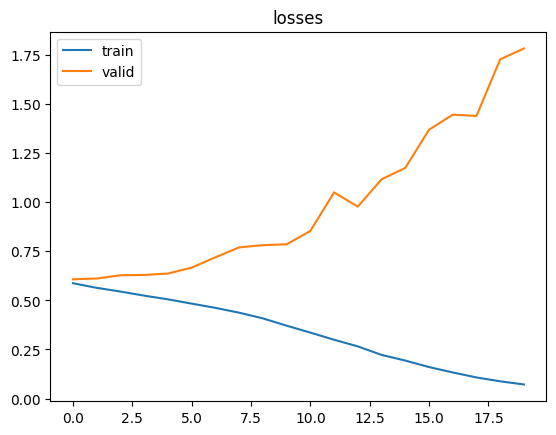

In [ ]:
import matplotlib.pyplot as plt

plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

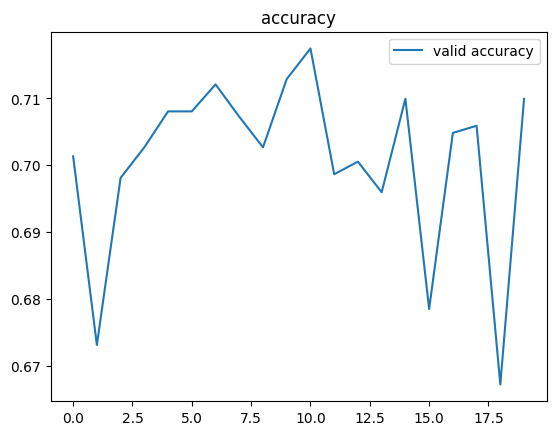

In [ ]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = trainer.evaluate(curr_dataloader=test_dataloader, check_len=True)

Len of current dataloader: 250


In [ ]:
print(f"Test loss {test_loss}, Test accuracy: {test_acc}")

Test loss 2.2296391886763742, Test accuracy: 0.673


In [ ]:
torch.save(subjectivity_classifier, "checkpoints.pth")